# Automatic Forecasting with TempEst-NEXT

This Notebook automatically generates forecasts out to 17 days for a specified watershed.  It will eventually include three approaches:

1. Pour point forecast: one watershed.
2. Nested forecast: the whole upstream system at kilometer resolution, run as tightly-nested lumped models.
3. Interpolated forecast: the whole upstream system, using kilometer-scale smart interpolation or a reach model between confluences.

For convenience, it is assumed that the downstream point is a USGS gage.  However, NEXT's automatic data retrieval tools can work with coordinates as well, with no gage required.

We will set up the watershed model based on 5 years of daymet data (2018-2022), then run the next 17 days with GFS data.

Note that this code can be readily modified for hindcasting, using either estimated or reforecasted weather, by just running the model for `ws_data` (possibly with a different time period) instead of `fcst_input`.  `ws_data` by default is daymet estimated weather.  This can be changed to HRRR archives (using `weather='hrrr'`) to evaluate short-term forecasting performance.  The GFS data source only goes back about a week, so that cannot be used for historical runs, but HRRR goes back to 2014.

# Setup and Watershed Identification

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


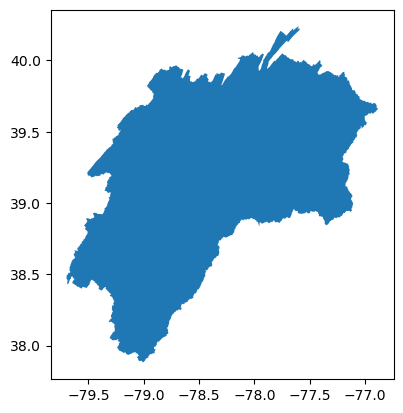

In [1]:
import NEXT
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import datetime
import dataretrieval.nwis as nwis
from pynhd import NLDI
from time import time
from NEXT.scripts.area_forecast import expand_line, expand_lines, run_forecasts, run_forecast, prepare_model, forecast_inputs
import seaborn as sns
# USGS gage as downstream location
# site = "10343500"    # Sagehen Creek nr Truckee, CA.  Small mountain watershed in Eastern Sierra.
site = "01646500"    # Potomac R near Little Falls Pump Stn., DC.  Large river near AGU24.  Possibly skewed by discharges.
# site = "01638500"    # Potomac R. at Point of Rocks, MD.  A little upstream to avoid the alteration.
NEXT.data.gage_geom(site)[0].plot()
model = NEXT.NEXT.from_pickle("coefs.pickle")  # prepare a coefficient estimation model
nldi = NLDI()
basepath = "/scratch/dphilippus/notebooks/forecast/"

# Pour Point Forecast

We are assuming the pour point is a USGS gage (which is not necessary).  If it has stream temperature, we can come back later and check our forecasts.

## Forecast

In [ ]:
forecast = run_forecast(model, site, basepath)
forecast

In [ ]:
# Plot the forecast
forecast.plot(x="date", y="temp.mod", layout="compressed")

## Validation

To validate a forecast, specify the date it was run on.  The notebook will retrieve river temperature observations and evaluate performance.

# Tightly Nested Watersheds

One approach to high-resolution modeling is to simply run a full, lumped watershed for each kilometer of river.  This is rather inefficient, since it involves a lot of redundant data retrieval, but it is straightforward because it can be run with only a lumped model.  It also serves to test the stability of model predictions in space.  The bulk of the analysis here is creating subwatersheds; after that, we simply run lumped models as per usual.

Since this isn't a good standard approach to high-resolution modeling, the watershed splicing is not built in to NEXT.

Kilometer spacing is not exact, since NHD+ spacing varies, but it is guaranteed to be less than 0.015 degrees, which is about 1.5 km in latitude and less (latitude-dependent) in longitude.

An alternative approach is to just interpolate along each linestring, instead of recursing.

## Set Up Coordinates

In [27]:
(ws, lat, lon, area) = NEXT.data.gage_geom(site)
coords = (lon, lat)
# resolution = 0.01  # 0.01 degrees is ~1.1 km latitude, ~0.9 km longitude
resolution = 0.1

In [28]:
def expand_line(line):
    count = line.length / resolution
    if count < 0.5:
        steps = []   # we don't want super-dense points on very short reaches
    elif count < 1.5:
        steps = [line.length]  # just the bottom
    else:
        steps = np.arange(resolution, line.length, resolution)
    return gpd.GeoSeries(line.interpolate(steps))

def expand_lines(geometry):
    return pd.concat([expand_line(g) for g in geometry])

<Axes: >

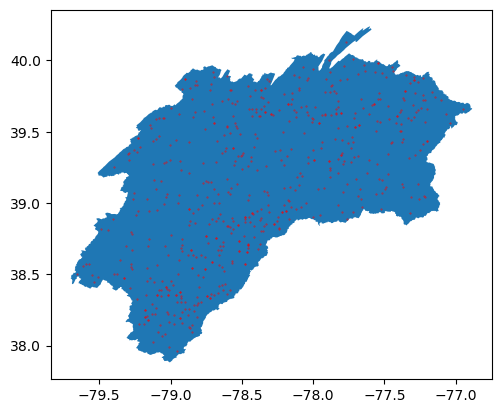

In [29]:
lines = nldi.navigate_byloc(coords, "upstreamTributaries", source="flowlines", distance=1000)
points = expand_lines(lines.geometry)
ax = ws.plot()
points.plot(ax=ax, c="red", markersize=0.1)

In [30]:
clist = [pt.coords[0] for pt in points]
print(len(clist))
clist[:5]

591


[(-77.321725905, 38.932502694),
 (-77.260312706, 39.0274828),
 (-77.223572306, 39.049196094),
 (-77.217317902, 39.045495093),
 (-77.311689205, 39.039943695)]

## Prepare Forecasts

To do this in many HPC runs, do the following.  Statics files start appearing after about 3 minutes (spinup time, etc).  Prepared data appeared 4 minutes further in.  ...aaand the forecast retrieval is obstinately not working.

In [4]:
print(f"python scripts/area_forecast.py {site} {basepath} [index] [Npartitions] 0.1 1000")

python scripts/area_forecast.py 01646500 /scratch/dphilippus/notebooks/forecast/ [index] [Npartitions] 0.1 1000


While we're at it, let's see how long this takes.

- Sagehen (19 points):
    - With full data retrieval: Approx. 1 hour, 3 min/ws.
    - With forecast retrieval only: 
    - Without (modeling only): ~instantaneous (2 seconds)
- Potomac (19,000 points, total area 27,000 km2) (10-km: 600 points)
    - With full data retrieval: specifically, the forecast data retrieval takes ~3 minutes. WTF?
    - With forecast retrieval only:
    - Modeling only: 

In [ ]:
def wrapper(op, start, crash=False, retry=True):
    try:
        result = op()
        delta = (time() - start) / 60
        print(f"\r{delta:08.2f}", end="")
        return result
    except Exception as e:
        if crash:
            raise e
        if retry:  # retry once
            return wrapper(op, start, crash, False)
        return None
fcst_run = run_forecasts(site, "coefs.pickle", basepath, 0.1, 1000)
start = time()
forecast_list = [
    wrapper(
        op,
        start,
        crash=False
    )
    for op in fcst_run
]
forecast = pd.concat(forecast_list)
runtime = (time() - start) / 3600
print(f"\rTook {runtime:.2f} hours")

## Plot Forecasts

Trends tend to be fairly similar (though varying in magnitude) within an area, since the region is affected by similar weather fronts.

We can also animate it.

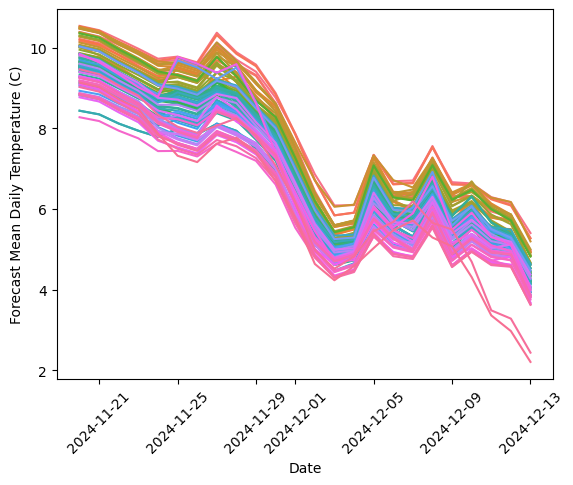

In [34]:
ax = sns.lineplot(forecast, x="date", y="temp.mod", hue="id")
ax.legend().remove()
ax.set_xlabel("Date")
ax.set_ylabel("Forecast Mean Daily Temperature (C)")
ax.tick_params(axis='x', rotation=45)

MovieWriter ffmpeg unavailable; using Pillow instead.


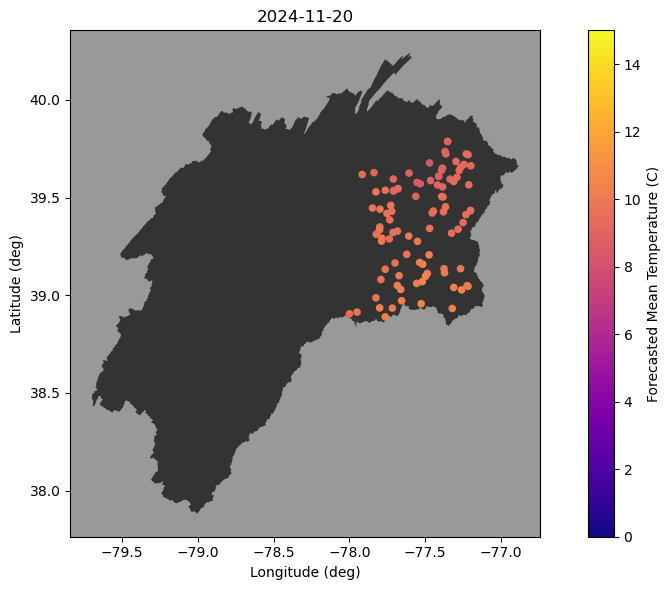

In [35]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(facecolor="#999")
dates = np.array(forecast["date"].unique(), dtype='datetime64[D]')
def animate(i):
    date = dates[i]
    fig.clear()
    ax = plt.axes(facecolor="#999")
    ws.plot(ax=ax, color="#333")
    forecast[forecast["date"] == date].plot.scatter(x="lon", y="lat", c="temp.mod", title=str(date), ax=ax, colormap="plasma", vmin=0, vmax=5 * (forecast["temp.mod"].max() // 5 + 1))
    ax.collections[1].colorbar.set_label("Forecasted Mean Temperature (C)")
    ax.set_xlabel("Longitude (deg)")
    ax.set_ylabel("Latitude (deg)")
    plt.tight_layout()

a = anim.FuncAnimation(fig, animate, interval=1000, frames=range(len(dates)))
a.save(f"forecast_anims/{site}_forecast.gif")